# Preserving regionally varying error bounds (regions of interest) with safeguards

In this example, we show how a regionally varying error bound for surface latent heat flux, based on the land-sea mask, can be provided by the safeguards.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-lh" / "data.nc")
ERA5_LH = ERA5["slhf"].sel(valid_time="2024-04-02T12:00:00")
ERA5_LSM = ERA5["lsm"].sel(valid_time="2024-04-02T12:00:00")

In [4]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [5]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [6]:
def plot_surface_latent_heat_flux(
    my_ERA5_LH: xr.Dataset,
    cr,
    chart,
    title,
    span,
    error=False,
    show_extend=True,
):
    import copy

    if error:
        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_LH - ERA5_LH).compute()

        err_LH = np.amax(np.abs(my_ERA5_LH - ERA5_LH))

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        da = my_ERA5_LH

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    if error:
        style._levels = earthkit.plots.styles.levels.Levels(
            np.linspace(-span, span, 22)
        )
        style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
        style._colors = "coolwarm"
    else:
        style._levels = earthkit.plots.styles.levels.Levels(
            np.linspace(-span, span, 22)
        )
        style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
        style._colors = "RdBu"

    extend_left = np.nanmin(da) < -span
    extend_right = np.nanmax(da) > span

    extend = (
        {
            (False, False): "neither",
            (True, False): "min",
            (False, True): "max",
            (True, True): "both",
        }[(extend_left, extend_right)]
        if show_extend
        else "neither"
    )

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-11)
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        chart.title(f"{title}\n" + rf"$L_{{{{\infty}}}}(\hat{{{{LH}}}})$={err_LH:.05}")
    else:
        chart.title(f"{title}\n")

    if error:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    counts, bins = np.histogram(da.values.flatten(), range=(-span, span), bins=21)
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    cax = cb.ax.inset_axes([0.0, 1.25, 1.0, 1.0])
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
    )
    cax.set_xlim(-span, span)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

## Compressing slhf with safeguards

We configure the safeguards with absolute error bounds of $10^{2}$ and $10^{4}$ $\text{J}/\text{m}^{2}$, which roughly match the orders of magnitude of surface latent heat flux above land and above the sea, respectively. Finally, we also configure safeguards with a regions of interest selector to apply these two error bounds based on the land-sea mask (where we define "sea" as $< 90\%$ land).

In [7]:
from numcodecs_safeguards.lossless import _default_lossless_for_safeguards

from compression_safeguards import Safeguards
from compression_safeguards.utils.bindings import Bindings

In [8]:
prediction = np.zeros_like(ERA5_LH.values)

In [9]:
lossless = _default_lossless_for_safeguards()

In [10]:
eb_low = dict(kind="eb", type="abs", eb=1e2)
eb_high = dict(kind="eb", type="abs", eb=1e4)

In [11]:
sg_low = Safeguards(safeguards=[eb_low])

correction_sg_low = sg_low.compute_correction(ERA5_LH.values, prediction)
encoded_sg_low = np.asarray(lossless.encode(correction_sg_low))

ERA5_LH_sg_low = ERA5_LH.copy(
    data=sg_low.apply_correction(prediction, correction_sg_low)
)

In [12]:
sg_high = Safeguards(safeguards=[eb_high])

correction_sg_high = sg_high.compute_correction(ERA5_LH.values, prediction)
encoded_sg_high = np.asarray(lossless.encode(correction_sg_high))

ERA5_LH_sg_high = ERA5_LH.copy(
    data=sg_high.apply_correction(prediction, correction_sg_high)
)

In [13]:
sg_roi = Safeguards(
    safeguards=[
        dict(
            kind="select",
            selector="lsm",
            safeguards=[
                # 0: absolute error for <90% land (sea)
                eb_high,
                # 1: absolute error for >=90% land (land)
                eb_low,
            ],
        ),
    ]
)

correction_sg_roi = sg_roi.compute_correction(
    ERA5_LH.values,
    prediction,
    late_bound=Bindings(
        # lsm: 1 for >=90% land, 0 otherwise
        lsm=(ERA5_LSM >= 0.9).values,
    ),
)
encoded_sg_roi = np.asarray(lossless.encode(correction_sg_roi))

ERA5_LH_sg_roi = ERA5_LH.copy(
    data=sg_roi.apply_correction(prediction, correction_sg_roi)
)

## Visual comparison of the error distributions for the surface latent heat flux

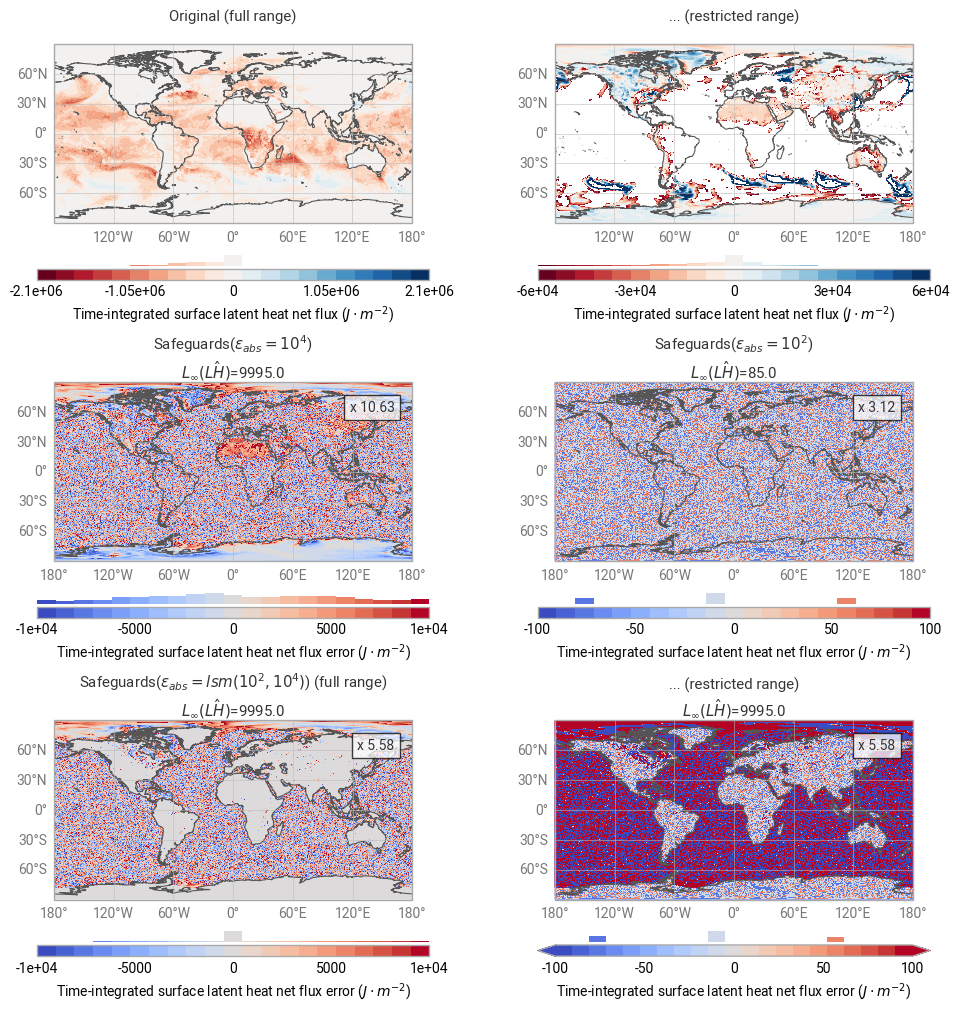

In [14]:
fig = earthkit.plots.Figure(rows=3, columns=2, size=(10, 10))

plot_surface_latent_heat_flux(
    ERA5_LH,
    1.0,
    fig.add_map(0, 0),
    "Original (full range)",
    span=2.1e6,
)
plot_surface_latent_heat_flux(
    ERA5_LH,
    1.0,
    fig.add_map(0, 1),
    "... (restricted range)",
    span=6e4,
    show_extend=False,
)

plot_surface_latent_heat_flux(
    ERA5_LH_sg_high,
    ERA5_LH.nbytes / encoded_sg_high.nbytes,
    fig.add_map(1, 0),
    r"Safeguards($\epsilon_{{abs}}=10^{{4}}$)",
    span=1e4,
    error=True,
)
plot_surface_latent_heat_flux(
    ERA5_LH_sg_low,
    ERA5_LH.nbytes / encoded_sg_low.nbytes,
    fig.add_map(1, 1),
    r"Safeguards($\epsilon_{{abs}}=10^{{2}}$)",
    span=1e2,
    error=True,
)

plot_surface_latent_heat_flux(
    ERA5_LH_sg_roi,
    ERA5_LH.nbytes / encoded_sg_roi.nbytes,
    fig.add_map(2, 0),
    r"Safeguards($\epsilon_{{abs}}=lsm(10^{{2}}, 10^{{4}})$) (full range)",
    span=1e4,
    error=True,
)
plot_surface_latent_heat_flux(
    ERA5_LH_sg_roi,
    ERA5_LH.nbytes / encoded_sg_roi.nbytes,
    fig.add_map(2, 1),
    r"... (restricted range)",
    span=1e2,
    error=True,
)

fig.save("latent-heat-flux.pdf")